# Inference in Pyro: From Stochastic Functions to Marginal Distributions

In [2]:
# import some dependencies
import numpy as np
import matplotlib.pyplot as plt

import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101);

In [3]:
def scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

In [8]:
posterior = pyro.infer.Importance(scale, num_samples=100)

In [16]:
guess = 8

marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess))
print(marginal())

tensor(8.4590)


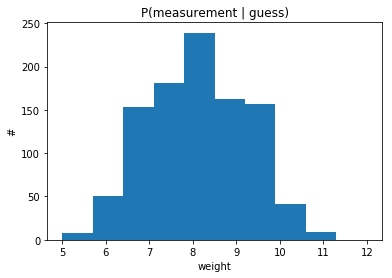

In [18]:
plt.hist([marginal().item() for _ in range(1000)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#");

## Conditioning Models on Data

In [22]:
def scale2(guess):
    weight = pyro.sample('weight', dist.normal(guess, 1.))
    tolerance = torch.abs(pyro.sample('tolerance', dist.normal(0.,1.)))
    measurement = pyro.sample('measurement', dist.normal(weight, tolerance))
    return measurement

In [28]:
conditioned_scale2_1 = pyro.condition(scale2, data = {'weight':9.2,'measurement' : 9.5})

In [52]:
def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={"measurement": measurement})(*args, **kwargs)

tensor(8.0990)


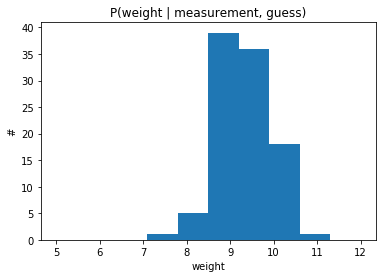

In [61]:
guess = 8.5
measurement = 9.5

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})

marginal = pyro.infer.EmpiricalMarginal(
    pyro.infer.Importance(conditioned_scale, num_samples=100).run(guess), sites="weight")

# The marginal distribution concentrates around the data
print(marginal())
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

tensor(9.0528)


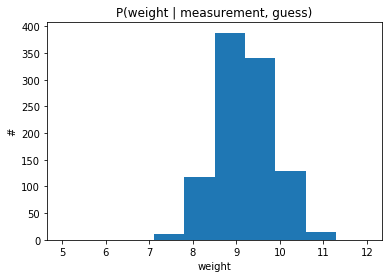

In [58]:
def scale_prior_guide(guess):
    return pyro.sample('weight', dist.Normal(guess, 1.0))

posterior = pyro.infer.Importance(conditioned_scale, guide = scale_prior_guide, num_samples=20)
margianl = pyro.infer.EmpiricalMarginal(posterior.run(guess), sites ='weight')
print(marginal())
plt.hist([marginal().item() for _ in range(1000)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

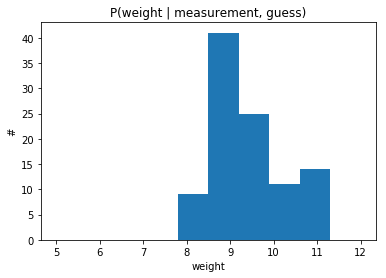

In [59]:
def scale_posterior_guide(measurement, guess):
    # note that torch.size(measurement, 0) is the total number of measurements
    # that we're conditioning on
    a = (guess + torch.sum(measurement)) / (measurement.size(0) + 1.0)
    b = 1. / (measurement.size(0) + 1.0)
    return pyro.sample("weight", dist.Normal(a, b))

posterior = pyro.infer.Importance(deferred_conditioned_scale,
                                  guide=scale_posterior_guide,
                                  num_samples=200)

marginal = pyro.infer.EmpiricalMarginal(posterior.run(torch.tensor([measurement]), guess), sites="weight")
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

## Variational Inference

In [72]:
def scale_parameterized_guide(guess):
    a = pyro.param('a', torch.randn(1) + guess)
    b = pyro.param('b', torch.randn(1))
    return pyro.sample('weight',dist.Normal(a,torch.abs(b)))

Text(0,0.5,'loss')

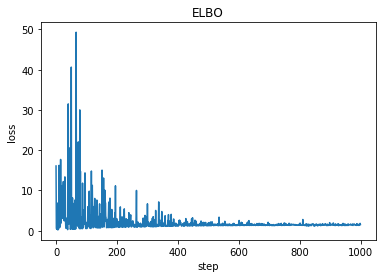

In [86]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                    guide=scale_parameterized_guide,
                    optim=pyro.optim.SGD({'lr':0.001}),
                    loss=pyro.infer.Trace_ELBO())
losses=[]
for t in range(1000):
    losses.append(svi.step(guess))
plt.plot(losses)
plt.title("ELBO")
plt.xlabel('step')
plt.ylabel('loss')

Text(0,0.5,'#')

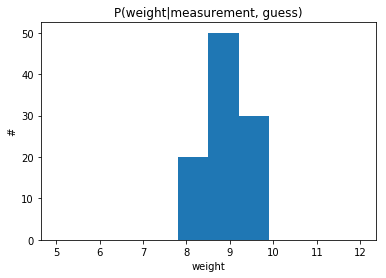

In [88]:
#Using the optimized guide to find the posterior distribution of weight:
posterior = pyro.infer.Importance(conditioned_scale, guide = scale_parameterized_guide, num_samples=10)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess), sites = 'weight')
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title('P(weight|measurement, guess)')
plt.xlabel('weight')
plt.ylabel('#')

Text(0,0.5,'#')

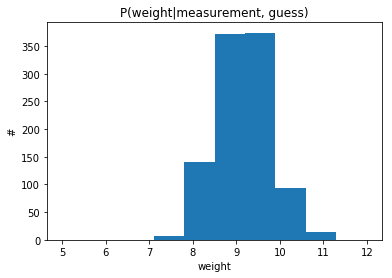

In [85]:
##Sampling from the guide directly:
plt.hist([scale_parameterized_guide(guess).item() for _ in range(1000)], range=(5.0,12.0))
plt.title('P(weight|measurement, guess)')
plt.xlabel('weight')
plt.ylabel('#')

In [93]:
posterior.run(guess)

TypeError: 'Importance' object is not iterable